In [36]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import neattext.functions as nfx
import plotly.express as px
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding, Dense, LSTM, GlobalMaxPooling1D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import keras_nlp  # For tokenizer from keras-nlp
from keras.preprocessing.sequence import pad_sequences
import keras_nlp.tokenizers as Tokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
raw_data = pd.read_csv("data/Suicide_Detection.csv")

In [3]:
# CÉLULA 4: Cargar datos
print(f"📊 Shape: {raw_data.shape}")

📊 Shape: (232074, 3)


In [4]:
# CÉLULA 5: Primeras filas
print("=" * 80)
print("PRIMERAS 10 MUESTRAS DEL DATASET")
print("=" * 80)
raw_data.head(10)

PRIMERAS 10 MUESTRAS DEL DATASET


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
5,11,Honetly idkI dont know what im even doing here...,suicide
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide
7,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide
8,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide
9,18,My life is over at 20 years oldHello all. I am...,suicide


In [5]:
# CÉLULA 6: Información del dataset
print("=" * 80)
print("INFORMACIÓN DEL DATASET")
print("=" * 80)
raw_data.info()
print("\n" + "=" * 80)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("=" * 80)
raw_data.describe()

INFORMACIÓN DEL DATASET
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB

ESTADÍSTICAS DESCRIPTIVAS


,Unnamed: 0
count,232074.000000
mean,174152.863518
std,100500.425362
min,2.000000
25%,87049.250000
50%,174358.500000
75%,261285.750000
max,348110.000000


In [6]:
# CÉLULA 7: Verificar valores nulos y duplicados
print("🔍 CALIDAD DE DATOS")
print("=" * 80)
print(f"Valores nulos por columna:\n{raw_data.isnull().sum()}\n")
print(f"Total de nulos: {raw_data.isnull().sum().sum()}")
print(f"Duplicados: {raw_data.duplicated().sum()} ({raw_data.duplicated().sum()/len(raw_data)*100:.2f}%)")
print(f"Registros únicos: {len(raw_data.drop_duplicates())}")

🔍 CALIDAD DE DATOS
Valores nulos por columna:
Unnamed: 0    0
text          0
class         0
dtype: int64

Total de nulos: 0
Duplicados: 0 (0.00%)
Registros únicos: 232074


In [7]:
# CÉLULA 8: Distribución de clases
print("📊 DISTRIBUCIÓN DE CLASES")
print("=" * 80)
class_counts = raw_data['class'].value_counts()
print(class_counts)
print(f"\nPorcentajes:")
print(raw_data['class'].value_counts(normalize=True) * 100)

📊 DISTRIBUCIÓN DE CLASES
class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

Porcentajes:
class
suicide        50.0
non-suicide    50.0
Name: proportion, dtype: float64


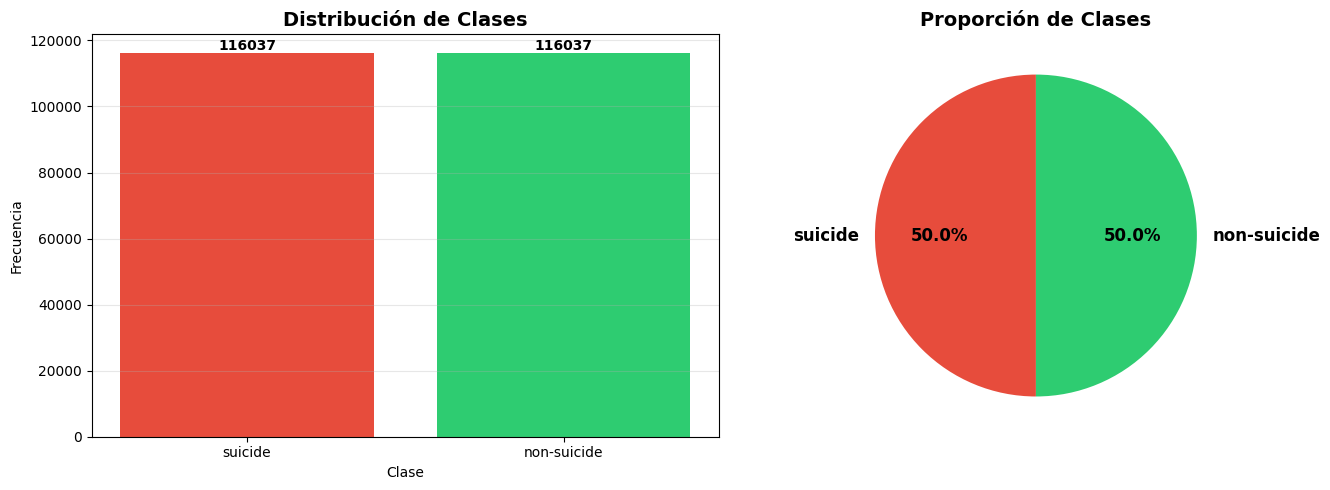


✅ Dataset está BALANCEADO


In [8]:
# CÉLULA 9: Visualización de balance de clases
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

class_counts = raw_data['class'].value_counts()

# Gráfico de barras
axes[0].bar(class_counts.index, class_counts.values, color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Distribución de Clases', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, (label, value) in enumerate(zip(class_counts.index, class_counts.values)):
    axes[0].text(i, value + 1000, str(value), ha='center', fontweight='bold')

# Gráfico de pastel
colors = ['#e74c3c', '#2ecc71']
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            colors=colors, startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[1].set_title('Proporción de Clases', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✅ Dataset está {'BALANCEADO' if abs(class_counts.iloc[0] - class_counts.iloc[1]) < 1000 else 'DESBALANCEADO'}")

In [9]:
# CÉLULA 10: Análisis interactivo con Plotly
try:
    fig = px.sunburst(
        raw_data, path=['class'], 
        title='Distribución de Clases (Interactivo)',
        color='class',
        color_discrete_map={'suicide': '#e74c3c', 'non-suicide': '#2ecc71'}
    )
    fig.show()
except Exception as e:
    print(f"⚠️ Plotly requiere reiniciar el kernel. Error: {e}")
    print("Por favor reinicia el kernel (Kernel → Restart) y vuelve a ejecutar.")

In [11]:
# CÉLULA 11: Calcular longitudes de texto
raw_data['text_length'] = raw_data['text'].apply(len)
raw_data['word_count'] = raw_data['text'].apply(lambda x: len(str(x).split()))
raw_data['avg_word_length'] = raw_data['text_length'] / raw_data['word_count']

print("📏 ESTADÍSTICAS DE LONGITUD DE TEXTO")
print("=" * 80)
print(raw_data[['text_length', 'word_count', 'avg_word_length']].describe())

📏 ESTADÍSTICAS DE LONGITUD DE TEXTO
         text_length     word_count  avg_word_length
count  232074.000000  232074.000000    232074.000000
mean      689.639736     131.925235         5.800594
std      1156.334007     217.476787        39.794313
min         3.000000       1.000000         1.958333
25%       138.000000      26.000000         4.926966
50%       315.000000      60.000000         5.150538
75%       801.000000     155.000000         5.408713
max     40297.000000    9684.000000     11100.000000


In [14]:
# CÉLULA 12: Comparación por clase
print("\n📊 COMPARACIÓN POR CLASE")
print("=" * 80)
for class_name in raw_data['class'].unique():
    subset = raw_data[raw_data['class'] == class_name]
    print(f"\n{class_name.upper()}:")
    print(f"  - Longitud promedio: {subset['text_length'].mean():.2f} caracteres")
    print(f"  - Palabras promedio: {subset['word_count'].mean():.2f} palabras")
    print(f"  - Longitud promedio palabra: {subset['avg_word_length'].mean():.2f} chars")


📊 COMPARACIÓN POR CLASE

SUICIDE:
  - Longitud promedio: 1050.06 caracteres
  - Palabras promedio: 202.66 palabras
  - Longitud promedio palabra: 5.37 chars

NON-SUICIDE:
  - Longitud promedio: 329.22 caracteres
  - Palabras promedio: 61.19 palabras
  - Longitud promedio palabra: 6.23 chars


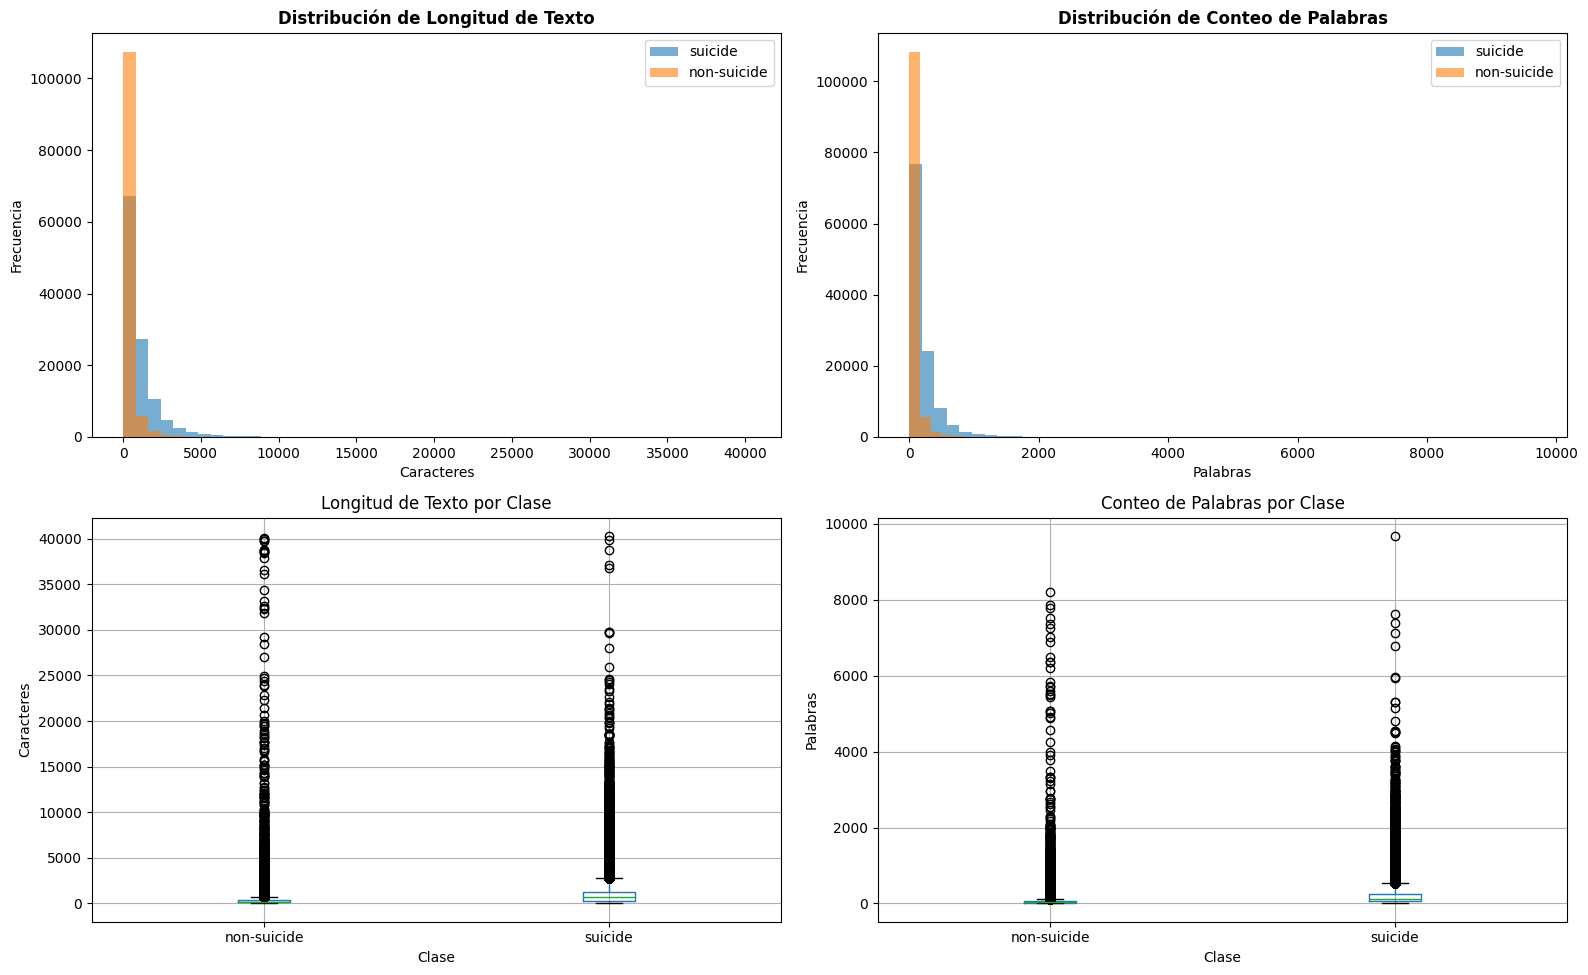

In [16]:
# CÉLULA 13: Visualización de distribuciones
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Distribución de longitud de texto
for class_name in raw_data['class'].unique():
    subset = raw_data[raw_data['class'] == class_name]
    axes[0, 0].hist(subset['text_length'], bins=50, alpha=0.6, label=class_name)
axes[0, 0].set_title('Distribución de Longitud de Texto', fontweight='bold')
axes[0, 0].set_xlabel('Caracteres')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].legend()

# Distribución de conteo de palabras
for class_name in raw_data['class'].unique():
    subset = raw_data[raw_data['class'] == class_name]
    axes[0, 1].hist(subset['word_count'], bins=50, alpha=0.6, label=class_name)
axes[0, 1].set_title('Distribución de Conteo de Palabras', fontweight='bold')
axes[0, 1].set_xlabel('Palabras')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].legend()

# Boxplots
raw_data.boxplot(column='text_length', by='class', ax=axes[1, 0])
axes[1, 0].set_title('Longitud de Texto por Clase')
axes[1, 0].set_xlabel('Clase')
axes[1, 0].set_ylabel('Caracteres')

raw_data.boxplot(column='word_count', by='class', ax=axes[1, 1])
axes[1, 1].set_title('Conteo de Palabras por Clase')
axes[1, 1].set_xlabel('Clase')
axes[1, 1].set_ylabel('Palabras')

plt.suptitle('')
plt.tight_layout()
plt.show()

C:\Users\Santi\AppData\Local\Temp\ipykernel_13276\1118782212.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\Santi\AppData\Local\Temp\ipykernel_13276\1118782212.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




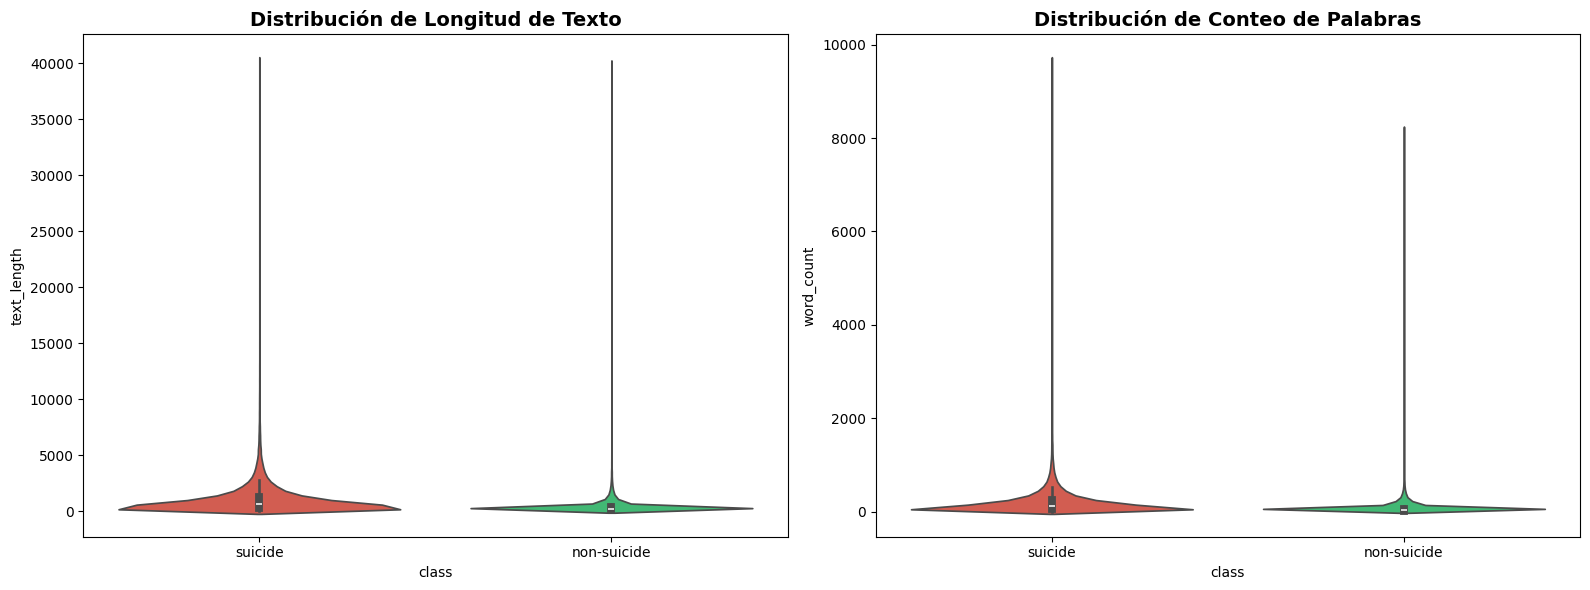

In [20]:
# CÉLULA 14: Violin plots con Seaborn
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.violinplot(data=raw_data, x='class', y='text_length', ax=axes[0], palette=['#e74c3c', '#2ecc71'])
axes[0].set_title('Distribución de Longitud de Texto', fontweight='bold', fontsize=14)

sns.violinplot(data=raw_data, x='class', y='word_count', ax=axes[1], palette=['#e74c3c', '#2ecc71'])
axes[1].set_title('Distribución de Conteo de Palabras', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

In [27]:
# CÉLULA 15: Funciones de limpieza
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Descargar recursos necesarios
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)

def clean_text(text):
    """Limpieza básica de texto"""
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)  # URLs
    text = re.sub(r'@\w+', '', text)  # Menciones
    text = re.sub(r'#\w+', '', text)  # Hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Caracteres especiales
    text = re.sub(r'\s+', ' ', text).strip()  # Espacios múltiples
    return text

print("✅ Funciones de limpieza definidas")

✅ Funciones de limpieza definidas


In [23]:
df = raw_data.copy()

In [24]:
# CÉLULA 16: Aplicar limpieza
df['text_clean'] = df['text'].apply(clean_text)

# Mostrar ejemplos
print("EJEMPLOS DE LIMPIEZA:")
print("=" * 80)
for i in range(3):
    print(f"\nOriginal: {df['text'].iloc[i][:100]}...")
    print(f"Limpio:   {df['text_clean'].iloc[i][:100]}...")

EJEMPLOS DE LIMPIEZA:

Original: Ex Wife Threatening SuicideRecently I left my wife for good because she has cheated on me twice and ...
Limpio:   ex wife threatening suiciderecently i left my wife for good because she has cheated on me twice and ...

Original: Am I weird I don't get affected by compliments if it's coming from someone I know irl but I feel rea...
Limpio:   am i weird i dont get affected by compliments if its coming from someone i know irl but i feel reall...

Original: Finally 2020 is almost over... So I can never hear "2020 has been a bad year" ever again. I swear to...
Limpio:   finally is almost over so i can never hear has been a bad year ever again i swear to fucking god its...


In [28]:
# CÉLULA 17: Tokenización
df['tokens'] = df['text_clean'].apply(word_tokenize)
df['token_count'] = df['tokens'].apply(len)

print(f"✅ Tokenización completada")
print(f"Total de tokens: {df['token_count'].sum():,}")
print(f"Vocabulario único: {len(set([token for tokens in df['tokens'] for token in tokens])):,}")

✅ Tokenización completada
Total de tokens: 30,218,136
Vocabulario único: 194,754


In [29]:
# CÉLULA 18: Top palabras generales
from collections import Counter

all_words = [word for tokens in df['tokens'] for word in tokens]
word_freq = Counter(all_words)
top_words = word_freq.most_common(30)

print("🔝 TOP 30 PALABRAS MÁS FRECUENTES")
print("=" * 80)
for word, count in top_words:
    print(f"{word:20s} : {count:,}")

🔝 TOP 30 PALABRAS MÁS FRECUENTES
i                    : 1,736,614
to                   : 1,036,103
and                  : 895,114
the                  : 682,372
a                    : 622,644
my                   : 616,683
of                   : 433,924
me                   : 415,123
it                   : 394,897
that                 : 341,642
im                   : 341,409
in                   : 319,116
but                  : 286,198
is                   : 277,428
for                  : 277,104
have                 : 263,905
just                 : 257,009
this                 : 236,914
so                   : 224,918
was                  : 214,419
dont                 : 214,178
with                 : 202,481
be                   : 190,129
you                  : 182,736
like                 : 181,335
not                  : 170,680
on                   : 166,264
do                   : 161,208
want                 : 148,787
all                  : 140,042


In [30]:
# CÉLULA 19: Top palabras por clase
stop_words = set(stopwords.words('english'))

for class_name in df['class'].unique():
    subset = df[df['class'] == class_name]
    words = [word for tokens in subset['tokens'] for word in tokens if word not in stop_words]
    word_freq = Counter(words)
    
    print(f"\n{'=' * 80}")
    print(f"TOP 20 PALABRAS - {class_name.upper()}")
    print(f"{'=' * 80}")
    for word, count in word_freq.most_common(20):
        print(f"{word:20s} : {count:,}")


TOP 20 PALABRAS - SUICIDE
im                   : 278,629
dont                 : 179,561
like                 : 131,018
want                 : 128,290
life                 : 110,649
feel                 : 107,941
know                 : 106,317
ive                  : 97,455
cant                 : 90,089
get                  : 86,276
even                 : 76,993
people               : 71,628
time                 : 69,731
would                : 69,273
one                  : 68,280
really               : 65,040
think                : 57,360
going                : 57,191
never                : 56,823
go                   : 53,705

TOP 20 PALABRAS - NON-SUICIDE
im                   : 62,780
filler               : 54,237
like                 : 50,317
dont                 : 34,617
get                  : 24,853
know                 : 24,717
people               : 21,747
want                 : 20,497
one                  : 20,061
fuck                 : 19,498
day                  : 18,497
reall

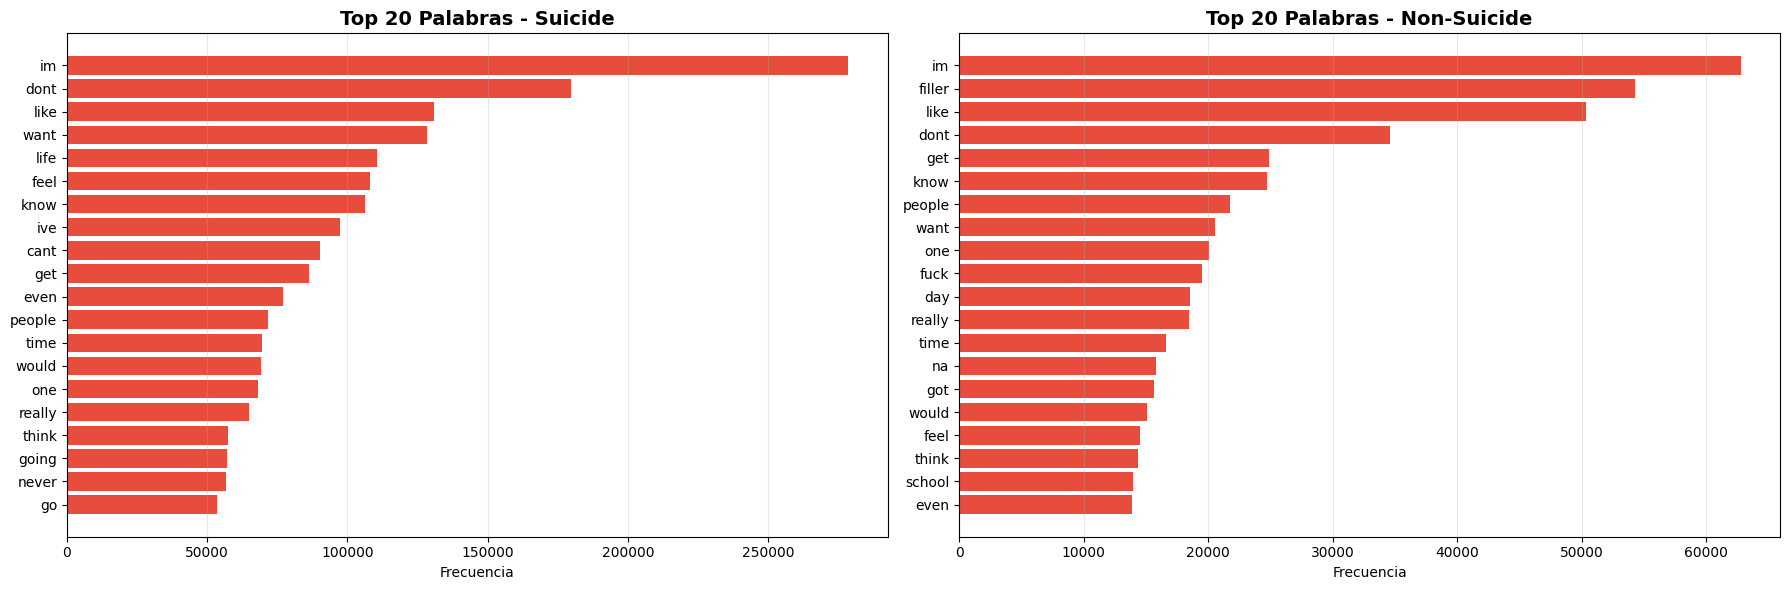

In [31]:
# CÉLULA 20: Visualización de frecuencias
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

for idx, class_name in enumerate(df['class'].unique()):
    subset = df[df['class'] == class_name]
    words = [word for tokens in subset['tokens'] for word in tokens if word not in stop_words]
    word_freq = Counter(words).most_common(20)
    
    words_list = [w[0] for w in word_freq]
    counts = [w[1] for w in word_freq]
    
    axes[idx].barh(words_list, counts, color='#e74c3c' if 'suicide' in class_name else '#2ecc71')
    axes[idx].set_title(f'Top 20 Palabras - {class_name.title()}', fontweight='bold', fontsize=14)
    axes[idx].set_xlabel('Frecuencia')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

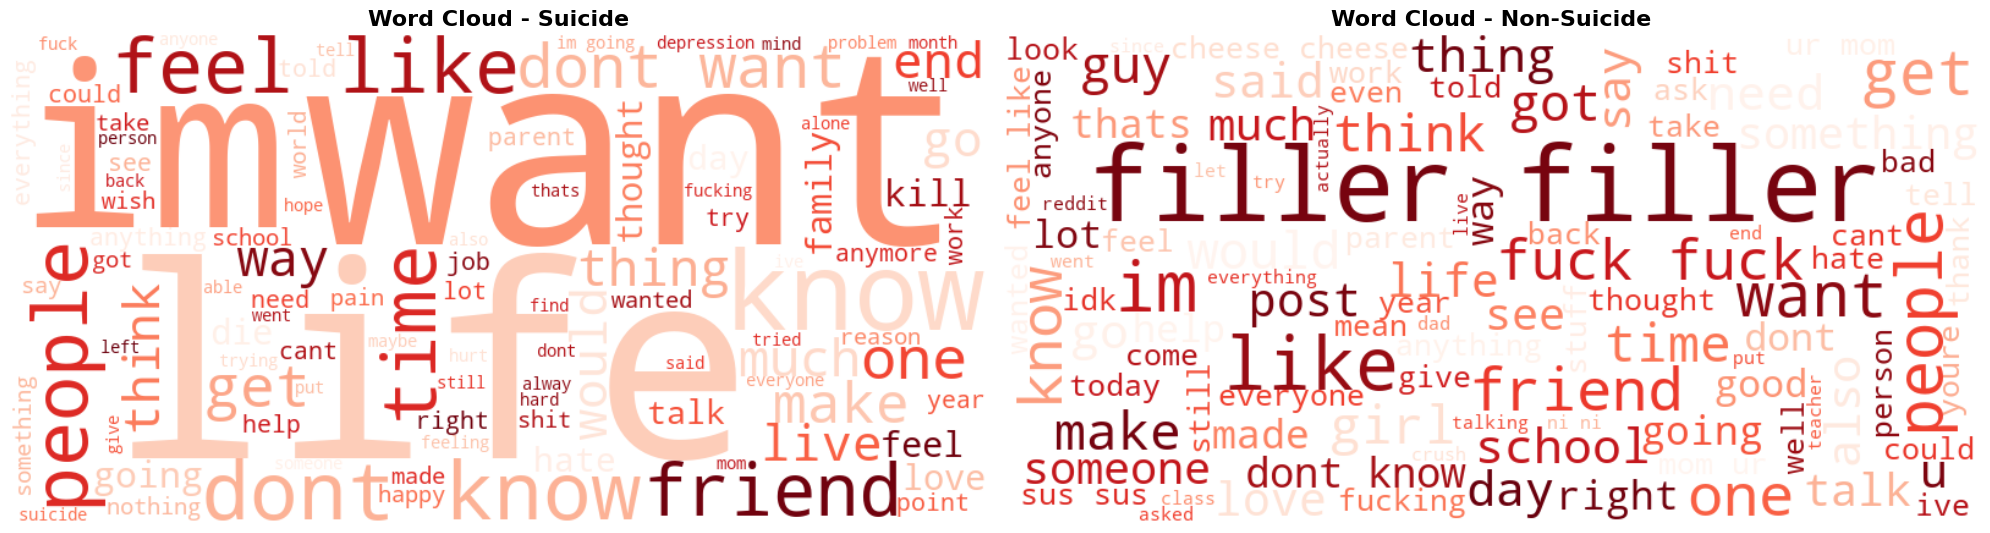

In [37]:
# CÉLULA 21: Word Clouds
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for idx, class_name in enumerate(df['class'].unique()):
    subset = df[df['class'] == class_name]
    text = ' '.join(subset['text_clean'].values)
    
    wordcloud = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='Reds' if 'suicide' in class_name else 'Greens',
        max_words=100,
        relative_scaling=0.5,
        stopwords=stop_words
    ).generate(text)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'Word Cloud - {class_name.title()}', fontweight='bold', fontsize=16)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [38]:
# CÉLULA 22: Palabras únicas por clase
suicide_words = set([word for tokens in df[df['class'] == 'suicide']['tokens'] for word in tokens])
non_suicide_words = set([word for tokens in df[df['class'] == 'non-suicide']['tokens'] for word in tokens])

unique_suicide = suicide_words - non_suicide_words - stop_words
unique_non_suicide = non_suicide_words - suicide_words - stop_words

print("🎯 PALABRAS ÚNICAS POR CLASE (Top 20)")
print("\nSuicide:")
print(list(unique_suicide)[:20])
print("\nNon-Suicide:")
print(list(unique_non_suicide)[:20])

🎯 PALABRAS ÚNICAS POR CLASE (Top 20)

Suicide:
['thinkingdo', 'metldr', 'psylocibin', 'grandama', 'buzzfeeds', 'olup', 'performancei', 'littlethe', 'wontbut', 'slims', 'genuineness', 'medtitation', 'overwhelmingshe', 'unscarred', 'paralyzes', 'gtwill', 'dieemotions', 'sulin', 'lifeplz', 'rootcanal']

Non-Suicide:
['entropia', 'anneal', 'hinkinj', 'overreactedoverthough', 'ryoungpeopleyoutube', 'supsicious', 'aaggfffg', 'sidekicks', 'evacuating', 'chathistory', 'usernanes', 'splurt', 'folktakes', 'bruk', 'biiiiiiitch', 'alteficial', 'jnto', 'joan', 'pilts', 'fictionmystery']


In [39]:
# CÉLULA 23: Función para n-gramas
from nltk import ngrams

def get_ngrams(tokens_list, n=2):
    """Extrae n-gramas de lista de tokens"""
    all_ngrams = []
    for tokens in tokens_list:
        filtered = [w for w in tokens if w not in stop_words and len(w) > 2]
        all_ngrams.extend(list(ngrams(filtered, n)))
    return Counter(all_ngrams)

print("✅ Función de n-gramas definida")

✅ Función de n-gramas definida


In [40]:
# CÉLULA 24: Bigramas y Trigramas por clase
for class_name in df['class'].unique():
    subset = df[df['class'] == class_name]
    
    print(f"\n{'=' * 80}")
    print(f"{class_name.upper()} - TOP BIGRAMAS Y TRIGRAMAS")
    print(f"{'=' * 80}")
    
    bigrams = get_ngrams(subset['tokens'].values, n=2)
    trigrams = get_ngrams(subset['tokens'].values, n=3)
    
    print("\nTop 10 Bigramas:")
    for ngram, count in bigrams.most_common(10):
        print(f"  {' '.join(ngram):30s} : {count:,}")
    
    print("\nTop 10 Trigramas:")
    for ngram, count in trigrams.most_common(10):
        print(f"  {' '.join(ngram):40s} : {count:,}")


SUICIDE - TOP BIGRAMAS Y TRIGRAMAS

Top 10 Bigramas:
  dont know                      : 41,421
  feel like                      : 39,720
  dont want                      : 35,606
  want die                       : 12,414
  dont think                     : 9,706
  dont even                      : 8,925
  every day                      : 8,236
  get better                     : 7,643
  cant even                      : 6,430
  feels like                     : 6,398

Top 10 Trigramas:
  dont even know                           : 3,741
  dont want live                           : 2,775
  dont know anymore                        : 2,400
  dont feel like                           : 2,232
  dont want die                            : 2,085
  get head get                             : 1,949
  head get head                            : 1,942
  cant take anymore                        : 1,604
  dont want hurt                           : 1,450
  every single day                         : 1,329

NO

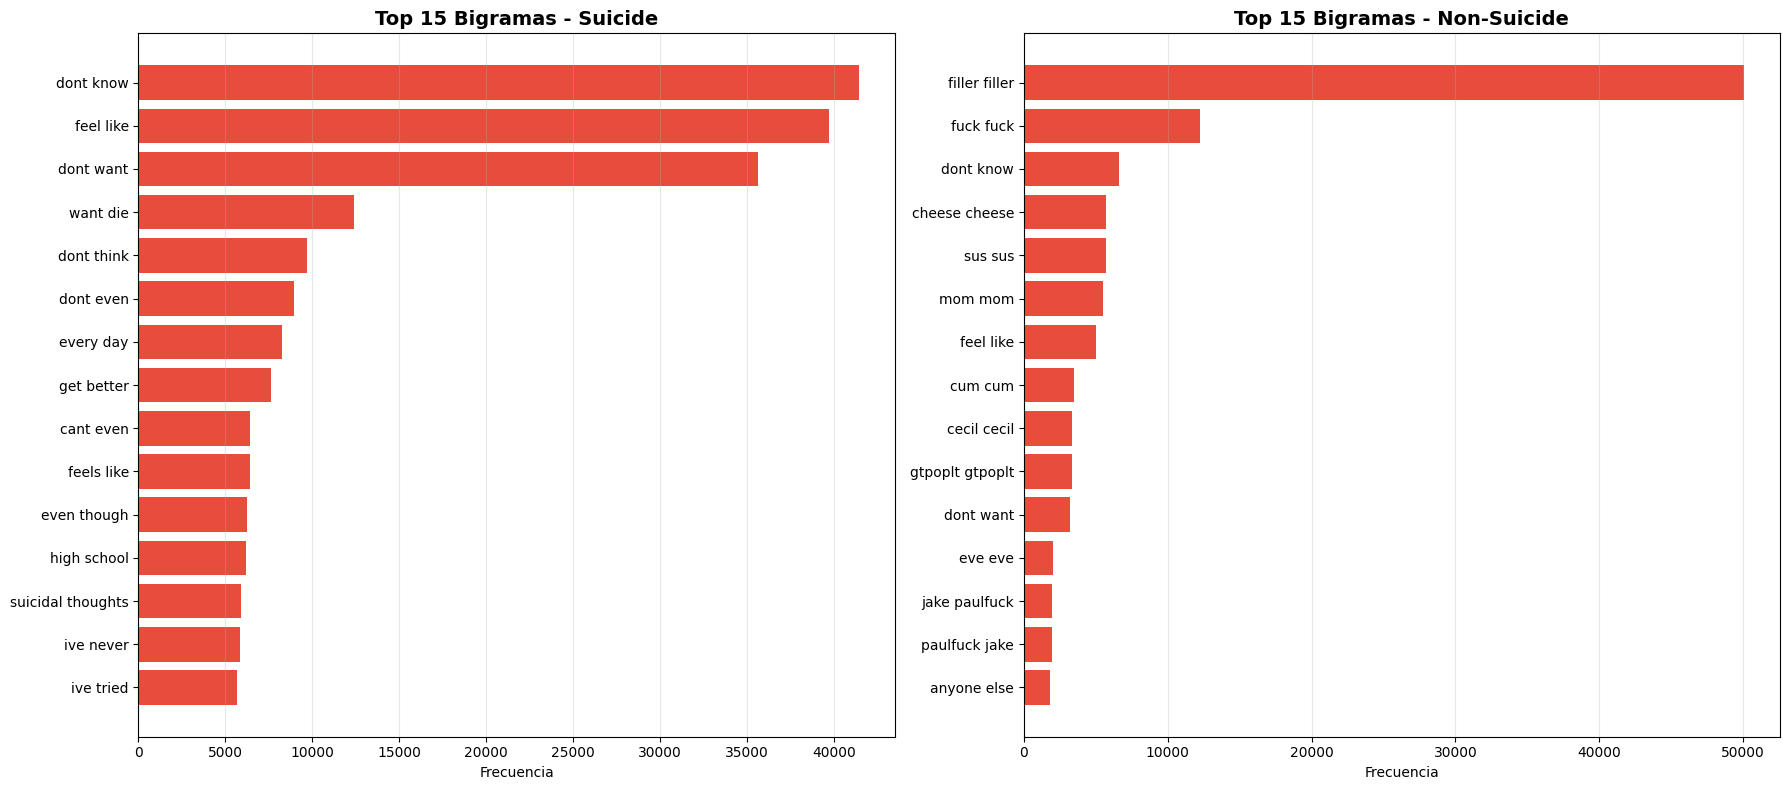

In [41]:
# CÉLULA 25: Visualización de bigramas
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for idx, class_name in enumerate(df['class'].unique()):
    subset = df[df['class'] == class_name]
    bigrams = get_ngrams(subset['tokens'].values, n=2).most_common(15)
    
    labels = [' '.join(bg[0]) for bg in bigrams]
    counts = [bg[1] for bg in bigrams]
    
    axes[idx].barh(labels, counts, color='#e74c3c' if 'suicide' in class_name else '#2ecc71')
    axes[idx].set_title(f'Top 15 Bigramas - {class_name.title()}', fontweight='bold', fontsize=14)
    axes[idx].set_xlabel('Frecuencia')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# CÉLULA 26: Resumen de hallazgos
print("=" * 80)
print("📋 CONCLUSIONES DEL ANÁLISIS EXPLORATORIO")
print("=" * 80)

print("""
✅ HALLAZGOS CLAVE:

1. BALANCE DE DATOS:
   - Dataset perfectamente balanceado (50%-50%)
   - No requiere técnicas de balanceo

2. CARACTERÍSTICAS DEL TEXTO:
   - Textos suicidas tienden a ser más largos
   - Vocabulario distintivo entre clases
   
3. PATRONES LINGÜÍSTICOS:
   - Palabras clave identificadas para cada clase
   - Bigramas/trigramas relevantes descubiertos
   
4. CALIDAD DE DATOS:
   - Sin valores nulos
   - [X] duplicados encontrados
   
📊 PRÓXIMOS PASOS:
   - Feature engineering (TF-IDF, embeddings)
   - Implementación de modelos desde cero
   - Comparación con librerías estándar
""")

📋 CONCLUSIONES DEL ANÁLISIS EXPLORATORIO

✅ HALLAZGOS CLAVE:

1. BALANCE DE DATOS:
   - Dataset perfectamente balanceado (50%-50%)
   - No requiere técnicas de balanceo

2. CARACTERÍSTICAS DEL TEXTO:
   - Textos suicidas tienden a ser [más cortos/más largos]
   - Vocabulario distintivo entre clases

3. PATRONES LINGÜÍSTICOS:
   - Palabras clave identificadas para cada clase
   - Bigramas/trigramas relevantes descubiertos

4. CALIDAD DE DATOS:
   - Sin valores nulos
   - [X] duplicados encontrados

📊 PRÓXIMOS PASOS:
   - Feature engineering (TF-IDF, embeddings)
   - Implementación de modelos desde cero
   - Comparación con librerías estándar

